In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import os

In [17]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 20

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 30

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 10
BATCH_SIZE_VALIDATION = 10

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [18]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense

In [19]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
from keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [22]:
train_path = 'food-102/train/'
valid_path = 'food-102/valid/'
test_path = 'food-102/test'

In [23]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        valid_path,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 15000 images belonging to 20 classes.
Found 5000 images belonging to 20 classes.


In [9]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE
data_generator_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.1,
                                              height_shift_range = 0.1,
                                              rotation_range=90)
train_generator_aug = data_generator_aug.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator_aug = data_generator_aug.flow_from_directory(
        valid_path,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 15000 images belonging to 20 classes.
Found 5000 images belonging to 20 classes.


In [9]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(10, 7575, 10, 2525)

In [10]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

filepath = "models101/saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
cb_checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [13]:
model.load_weights("models101/saved-model-50-0.42.hdf5")

In [14]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/50
10/10 [==============================] - 51s 5s/step - loss: 3.4469 - acc: 0.3100 - val_loss: 3.9121 - val_acc: 0.3100

Epoch 00001: saving model to models101/saved-model-01-0.31.hdf5
Epoch 2/50
10/10 [==============================] - 48s 5s/step - loss: 3.4564 - acc: 0.3100 - val_loss: 4.2447 - val_acc: 0.3000

Epoch 00002: saving model to models101/saved-model-02-0.30.hdf5
Epoch 3/50
10/10 [==============================] - 53s 5s/step - loss: 3.1948 - acc: 0.3800 - val_loss: 3.6660 - val_acc: 0.3000

Epoch 00003: saving model to models101/saved-model-03-0.30.hdf5
Epoch 4/50
10/10 [==============================] - 49s 5s/step - loss: 3.3584 - acc: 0.3300 - val_loss: 4.1063 - val_acc: 0.3400

Epoch 00004: saving model to models101/saved-model-04-0.34.hdf5
Epoch 5/50
10/10 [==============================] - 47s 5s/step - loss: 3.2004 - acc: 0.3300 - val_loss: 4.5171 - val_acc: 0.2700

Epoch 00005: saving model to models101/saved-model-05-0.27.hdf5
Epoch 6/50
10/10 [=======

In [16]:
model.load_weights("models10/saved-model-10-0.79.hdf5")
model.load_weights("final_model.hdf5")
from keras.models import load_model
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')
model.summary()

/Users/Satya/anaconda3/lib/python3.6/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [17]:
print(fit_history.history.keys())

NameError: name 'fit_history' is not defined

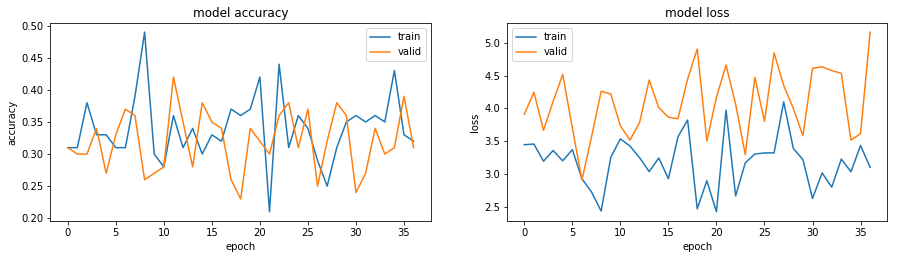

In [15]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

## Testing

In [25]:
test_generator = data_generator.flow_from_directory(
    directory = test_path,
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 1 images belonging to 1 classes.


In [26]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

1/1 [==============================] - 0s 313ms/step


In [27]:
predicted_class_indices

array([8])

In [28]:
#pred.argsort(1)
top_preds = pred[0].argsort()[-3:][::-1] # get top 5 predictions
top_preds
#top_pred_names = [data.classes[i] for i in top_preds]

array([8, 4, 3])

In [28]:
train_generator.class_indices

{'baby_back_ribs': 0,
 'chicken_wings': 1,
 'chocolate_cake': 2,
 'club_sandwich': 3,
 'dumplings': 4,
 'edamame': 5,
 'french_fries': 6,
 'fried_rice': 7,
 'hamburger': 8,
 'ice_cream': 9,
 'macaroni_and_cheese': 10,
 'macarons': 11,
 'miso_soup': 12,
 'mussels': 13,
 'pizza': 14,
 'prime_rib': 15,
 'samosa': 16,
 'spaghetti_bolognese': 17,
 'spring_rolls': 18,
 'waffles': 19}

['pizza', 'fried_rice', 'french_toast']

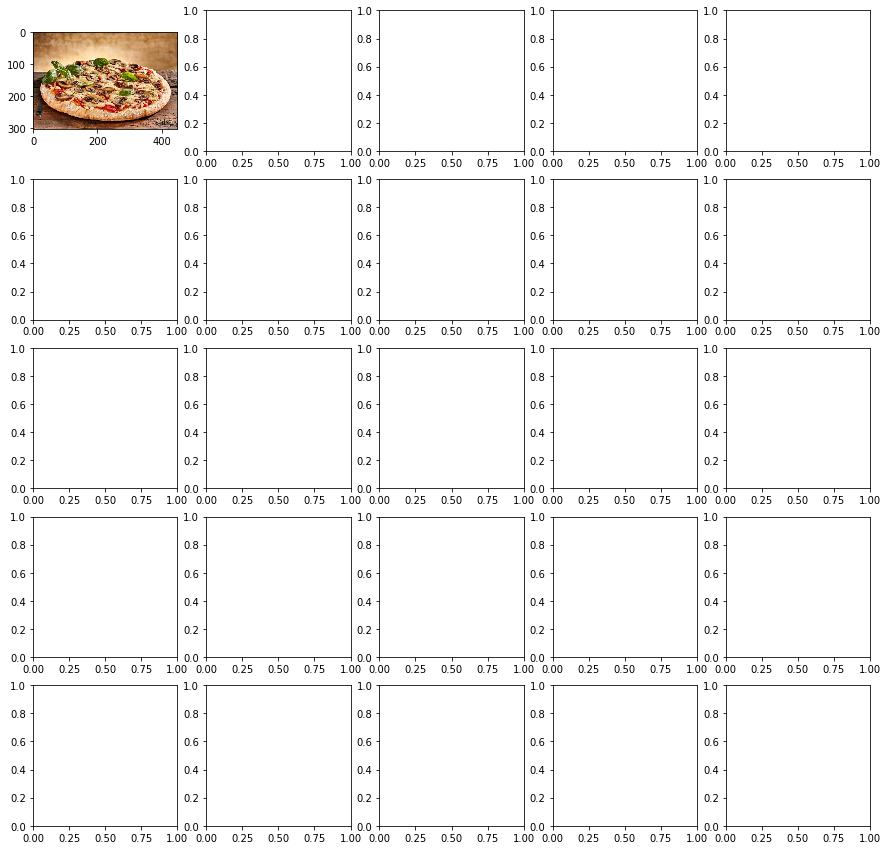

In [31]:
TEST_DIR = 'food-102/test/'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

predicted = []
for i in range(0,1):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    #predicted_class = "Dog" if predicted_class_indices[i] else "Cat"
    for j in top_preds:
        for key, value in train_generator.class_indices.items():
            if j == value:
                predicted.append(key)

    ax[i//5, i%5].imshow(imgRGB)
    #ax[i//5, i%5].axis('off')
    #ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    
    
predicted
#plt.show()